In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from collections import defaultdict

#preprocessing and resnet
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input


#save processed data
import joblib


#LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional

#VISULAIZATION
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

#pip install opencv-python numpy matplotlib scikit-learn 

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# run this to not get outflow errro 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)


In [5]:
def extract_frames_from_videos(video_folder, output_folder, name): # gets input videos folder , image output folder and the real/fake 
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)


    video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))] 
    maxframecount=0
    sequence_number = 1 

    for video_file in video_files:
        video_path = os.path.join(video_folder, video_file)
        video_name = os.path.splitext(video_file)[0]  # Extract the video name 
        
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        saved_frame_count = 0
        

        while True:
            ret, frame = cap.read()

            if not ret:
                break

            # Save every 40th frame
            if frame_count % 40 == 0:
                frame_file_name = os.path.join(
                    output_folder, f"{name}_sequence{sequence_number:02d}_frame{saved_frame_count:04d}.jpg"
                )
                cv2.imwrite(frame_file_name, frame)
                saved_frame_count += 1

            frame_count += 1

        cap.release()
        sequence_number += 1  

        if(maxframecount<saved_frame_count):
            maxframecount=saved_frame_count

    print(f"Processed {len(video_files)} videos. Frames saved to {output_folder}")
    print("max frame count: ",maxframecount)


In [8]:
video_folder = 'data/real'
output_folder = 'real'
extract_frames_from_videos(video_folder, output_folder,output_folder)

Processed 250 videos. Frames saved to real
max frame count:  19


In [9]:
video_folder = 'data/fake'
output_folder = 'fake'
extract_frames_from_videos(video_folder, output_folder,output_folder)

Processed 500 videos. Frames saved to fake
max frame count:  14


In [33]:
def convert_png_to_jpg(folder_path):
    """
    Converts all PNG images in a folder to JPG format.

    Args:
        folder_path (str): Path to the folder containing PNG images.

    Returns:
        None
    """
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return

    # List all PNG files
    png_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".png")]

    if not png_files:
        print(f"No PNG images found in {folder_path}")
        return

    print(f"Converting {len(png_files)} PNG images to JPG...")

    for png_file in png_files:
        png_path = os.path.join(folder_path, png_file)
        jpg_path = os.path.join(folder_path, os.path.splitext(png_file)[0] + ".jpg")

        # Read the PNG image
        img = cv2.imread(png_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"Error: Could not read image {png_path}")
            continue  # Skip this file

        # Convert and save as JPG
        cv2.imwrite(jpg_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

        # Optionally, delete the original PNG file
        os.remove(png_path)

        print(f"Converted {png_file} -> {os.path.basename(jpg_path)}")

    print("Conversion completed!")

In [ ]:
convert_png_to_jpg("denoised_enhanced/real")

In [ ]:
convert_png_to_jpg("denoised_enhanced/fake")

In [45]:
import os
folder_path = "denoised_enhanced/fake"

for filename in os.listdir(folder_path):
    new_name = filename.strip().replace(" ", "_")
    os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))

print("Renaming complete!")


Renaming complete!


In [46]:
import os
folder_path = "denoised_enhanced/real"

for filename in os.listdir(folder_path):
    new_name = filename.strip().replace(" ", "_")
    os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))

print("Renaming complete!")

Renaming complete!


In [49]:
import re

real_or_fake = "fake"  # Change to "real" if needed
pattern = re.compile(rf"{real_or_fake}_sequence(\d+)_frame(\d+)\.jpg", re.IGNORECASE)

filenames = [
    "fake_sequence01_frame0000.jpg",
    "fake_sequence01_frame0001.jpg",
    "fake_sequence01_frame0002.jpg",
    "fake_sequence02_frame0000.jpg",
    "fake_sequence02_frame0001.jpg",
]

# Check which filenames match
for filename in filenames:
    match = pattern.match(filename)
    if match:
        print(f"Matched: {filename} -> Sequence: {match.group(1)}, Frame: {match.group(2)}")
    else:
        print(f"Not matched: {filename}")


Matched: fake_sequence01_frame0000.jpg -> Sequence: 01, Frame: 0000
Matched: fake_sequence01_frame0001.jpg -> Sequence: 01, Frame: 0001
Matched: fake_sequence01_frame0002.jpg -> Sequence: 01, Frame: 0002
Matched: fake_sequence02_frame0000.jpg -> Sequence: 02, Frame: 0000
Matched: fake_sequence02_frame0001.jpg -> Sequence: 02, Frame: 0001


In [14]:
def read_frames_by_sequence(folder_path, real_or_fake,label):
    """
    Reads frames from a folder, organizes them by sequence, and associates a label.
    
    Args:
        folder_path (str): Path to the folder containing the frames.
        label (int): Label for the frames (e.g., 0 for real, 1 for fake).

    Returns:
        data (list): List of tuples [(sequence_frames, label), ...].
    """
    sequence_dict = defaultdict(list)


    pattern = re.compile(rf"{real_or_fake}_sequence(\d+)_frame(\d+).png")     # Regular expression to extract sequence and frame numbers

    # Iterate over files in the folder
    for file_name in sorted(os.listdir(folder_path)):
        match = pattern.match(file_name)
        if match:
            sequence_id, frame_id = map(int, match.groups())
            file_path = os.path.join(folder_path, file_name)
            sequence_dict[sequence_id].append((frame_id, file_path))
    
    data = []

    # Sort frames within each sequence and load frames
    for sequence_id, frames in sequence_dict.items():
        frames = sorted(frames, key=lambda x: x[0])  # Sort by frame number
        frame_paths = [frame[1] for frame in frames]

        # Read frames into memory
        sequence_frames = [cv2.imread(frame_path) for frame_path in frame_paths]
        data.append((sequence_frames, label))

    return data


In [44]:
from PIL import Image
img = Image.open("E:/FAST/mid 2 eval/denoised_enhanced/fake/fake_sequence01_frame0000.jpg")
img.show()


In [15]:
real_folder = "generated_enhanced/real"
fake_folder = "generated_enhanced/fake"

real_data = read_frames_by_sequence(real_folder, 'real',1)  # Label 1 for real
fake_data = read_frames_by_sequence(fake_folder,'fake',0)  # Label 0 for fake

# Combine real and fake data
all_data = real_data + fake_data


In [13]:
all_data

[]

In [40]:
folder_path = "your_folder_path"
print("All files in directory:", os.listdir(real_folder))


All files in directory: ['real_sequence01_frame0000.jpg', 'real_sequence01_frame0001.jpg', 'real_sequence01_frame0002.jpg', 'real_sequence01_frame0003.jpg', 'real_sequence01_frame0004.jpg', 'real_sequence01_frame0005.jpg', 'real_sequence01_frame0006.jpg', 'real_sequence01_frame0007.jpg', 'real_sequence01_frame0008.jpg', 'real_sequence01_frame0009.jpg', 'real_sequence01_frame0010.jpg', 'real_sequence01_frame0011.jpg', 'real_sequence02_frame0000.jpg', 'real_sequence02_frame0001.jpg', 'real_sequence02_frame0002.jpg', 'real_sequence02_frame0003.jpg', 'real_sequence02_frame0004.jpg', 'real_sequence02_frame0005.jpg', 'real_sequence02_frame0006.jpg', 'real_sequence02_frame0007.jpg', 'real_sequence03_frame0000.jpg', 'real_sequence03_frame0001.jpg', 'real_sequence03_frame0002.jpg', 'real_sequence03_frame0003.jpg', 'real_sequence03_frame0004.jpg', 'real_sequence03_frame0005.jpg', 'real_sequence03_frame0006.jpg', 'real_sequence03_frame0007.jpg', 'real_sequence03_frame0008.jpg', 'real_sequence04_f

In [8]:
def display_first_5_frames(data):

    for i, (frames, label) in enumerate(data):
        print(f"Displaying sequence {i+1} with label {label}")
        
        for j, frame in enumerate(frames[:5]):  # Display only the first 5 frames
            cv2.imshow(f"Sequence {i+1} - Frame {j+1} (Label: {label})", frame)
            
            
            print(f"Press any key to close Frame {j+1} of Sequence {i+1}")
            cv2.waitKey(0)  # Wait indefinitely for a key press
            cv2.destroyAllWindows()

        print(f"Completed displaying first 5 frames for sequence {i+1}")
        
        
        if i == 0:  # Change this to -1 if you want to show all sequences
            break


In [16]:
display_first_5_frames(all_data)


Displaying sequence 1 with label 1
Press any key to close Frame 1 of Sequence 1
Press any key to close Frame 2 of Sequence 1
Press any key to close Frame 3 of Sequence 1
Press any key to close Frame 4 of Sequence 1
Press any key to close Frame 5 of Sequence 1
Completed displaying first 5 frames for sequence 1


In [17]:

resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg') # Load the pre-trained ResNet50 model (without the top classification layer)

def resize_frame(frame, size=(224, 224)):
    """Resize frame to the specified size and ensure it's RGB (3 channels)."""
    frame_resized = cv2.resize(frame, size)
    
    # Ensure the frame is 3 channels (RGB), convert grayscale to RGB if necessary
    if len(frame_resized.shape) == 2:  
        frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_GRAY2RGB)
    
    
    frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB) # Convert from BGR (OpenCV) to RGB 
    
    return frame_resized

def normalize_frame(frame): #not used try to use in next experimentation 
    
    return frame / 255.0 #normalise to 0-1 

def extract_resnet_features(frame):

    frame_resized = resize_frame(frame)
    frame_resized = np.expand_dims(frame_resized, axis=0)  # Add batch dimension
    frame_resized = preprocess_input(frame_resized)  # Preprocessing for ResNet50 built in function

    features = resnet_model.predict(frame_resized)
    
    return features.flatten()  # Flatten to 1D array for LSTM input

def pad_sequence(sequence, max_length, feature_size=2048):
    """Pad the sequence to match the max_length with zeros."""
    # Initialize the padded sequence with zeros
    padded_sequence = np.zeros((max_length, feature_size), dtype=np.float32)
    
    for i in range(len(sequence)):
        padded_sequence[i] = sequence[i]  # Ensure sequence frames are feature vectors
    
    return padded_sequence

def preprocess_sequence(sequence, max_length, feature_size=2048):
    """Preprocess a sequence of frames: extract ResNet features, normalize, and pad."""
    # Extract features from each frame using ResNet
    sequence_features = [extract_resnet_features(frame) for frame in sequence]
    
    return pad_sequence(sequence_features, max_length, feature_size)

def prepare_data(all_data, max_sequence_length=30, feature_size=2048):
    """Preprocess all sequences and return prepared data."""
    processed_data = []
    
    for sequence, label in all_data:
        # Preprocess the sequence and append to processed data
        processed_sequence = preprocess_sequence(sequence, max_sequence_length, feature_size)
        processed_data.append((processed_sequence, label))

    return processed_data


In [18]:
processed_data = prepare_data(all_data, max_sequence_length=19)

1/1 [==============================] - 0s 14ms/step


In [19]:
# Check the shape of the processed data
for i, (sequence, label) in enumerate(processed_data[:5]):  
    print(f"Processed sequence {i + 1} shape: {sequence.shape}")
    print(f"Label: {label}")


Processed sequence 1 shape: (19, 2048)
Label: 1
Processed sequence 2 shape: (19, 2048)
Label: 1
Processed sequence 3 shape: (19, 2048)
Label: 1
Processed sequence 4 shape: (19, 2048)
Label: 1
Processed sequence 5 shape: (19, 2048)
Label: 1


In [20]:
# Check pixel values for the first frame of the first sequence
sample_frame = processed_data[0][0][0]  # First frame of the first sequence
print(f"Sample frame shape: {sample_frame.shape}")
print(f"Pixel values of the sample frame (min, max): ({sample_frame.min()}, {sample_frame.max()})")


Sample frame shape: (2048,)
Pixel values of the sample frame (min, max): (0.0, 9.224075317382812)


In [21]:
# Check the shape of the first sequence after padding
print(f"Shape of padded sequence: {processed_data[0][0].shape}")


Shape of padded sequence: (19, 2048)


In [22]:
len(processed_data)

750

In [23]:
labels = [label for _, label in processed_data]
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Label distribution: {dict(zip(unique_labels, counts))}")


Label distribution: {0: 500, 1: 250}


In [24]:
# Save the processed data to a file
joblib.dump(processed_data, 'processed_data.joblib')

print("Data saved successfully!")


Data saved successfully!


In [2]:
# Load the processed data from the file
processed_data = joblib.load('processed_data.joblib')

print("Data loaded successfully!")


Data loaded successfully!


In [25]:
# Each sequence has shape (videos_num, frame_num, featurevector)

def split_data(all_data, test_size=0.2, val_size=0.1):
    sequences, labels = zip(*all_data)  
    sequences = np.array(sequences)
    labels = np.array(labels)
    
   
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=test_size, random_state=42)
    
    # split train+validation into train and validation sets
    val_fraction = val_size / (1 - test_size)  # Adjust for remaining data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_fraction, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (525, 19, 2048), Validation shape: (75, 19, 2048), Test shape: (150, 19, 2048)


In [18]:
#kind of redundant

def reshape_for_lstm(data):
    """Reshape video data for LSTM input by flattening frames."""
    return np.array([video.reshape(video.shape[0], -1) for video in data])  

# Reshape train, validation, and test sets
X_train = reshape_for_lstm(X_train)
X_val = reshape_for_lstm(X_val)
X_test = reshape_for_lstm(X_test)

print(f"Train reshaped: {X_train.shape}, Validation reshaped: {X_val.shape}, Test reshaped: {X_test.shape}")


Train reshaped: (133, 19, 2048), Validation reshaped: (20, 19, 2048), Test reshaped: (39, 19, 2048)


In [26]:
#clear memory
from tensorflow.keras import backend as K
K.clear_session()


In [27]:
def build_lstm_model(input_shape, output_units=1):
    model = Sequential()
    
    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    
    # Second Bidirectional LSTM layer (with return_sequences=False for final output)
    model.add(Bidirectional(LSTM(128, return_sequences=False)))  
    model.add(Dropout(0.3))
    
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    
    # Output layer: binary classification (single output)
    model.add(Dense(output_units, activation='sigmoid'))  # Binary classification (output shape: (None, 1))
    

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
sequence_length = 19  
feature_size = 2048  # ResNet50 feature size (flattened)
input_shape = (sequence_length, feature_size)  # Sequence length and feature size
model = build_lstm_model(input_shape=input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 19, 256)          2229248   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 19, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [28]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=4,
    epochs=100,
    verbose=1
)


Epoch 1/100
132/132 [==============================] - 6s 17ms/step - loss: 0.4842 - accuracy: 0.7752 - val_loss: 0.3859 - val_accuracy: 0.8667
Epoch 2/100
132/132 [==============================] - 1s 9ms/step - loss: 0.3128 - accuracy: 0.9029 - val_loss: 0.2262 - val_accuracy: 0.9200
Epoch 3/100
132/132 [==============================] - 1s 8ms/step - loss: 0.2572 - accuracy: 0.9200 - val_loss: 0.4241 - val_accuracy: 0.8400
Epoch 4/100
132/132 [==============================] - 1s 8ms/step - loss: 0.2299 - accuracy: 0.9314 - val_loss: 0.1993 - val_accuracy: 0.9333
Epoch 5/100
132/132 [==============================] - 1s 8ms/step - loss: 0.2280 - accuracy: 0.9333 - val_loss: 0.1974 - val_accuracy: 0.9600
Epoch 6/100
132/132 [==============================] - 1s 8ms/step - loss: 0.2131 - accuracy: 0.9371 - val_loss: 0.2208 - val_accuracy: 0.9333
Epoch 7/100
132/132 [==============================] - 1s 8ms/step - loss: 0.2174 - accuracy: 0.9371 - val_loss: 0.2433 - val_accuracy: 0.933

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


5/5 [==============================] - 0s 18ms/step - loss: 0.4755 - accuracy: 0.9333
Test Loss: 0.47554677724838257, Test Accuracy: 0.9333333373069763


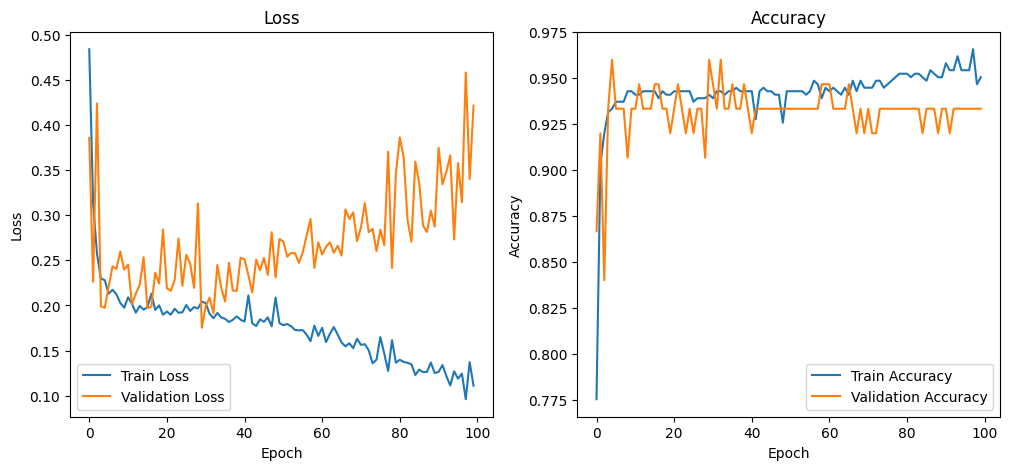

In [31]:
def plot_training_history(history):
    """Plot training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Visualize
plot_training_history(history)


5/5 [==============================] - 1s 15ms/step


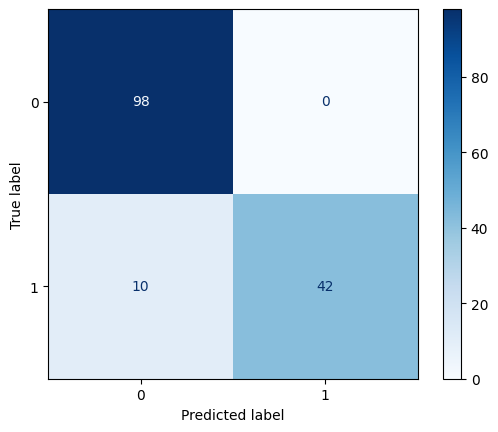

In [32]:
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Blues')


Precision: 1.0
Recall: 0.8076923076923077
F1 Score: 0.8936170212765957


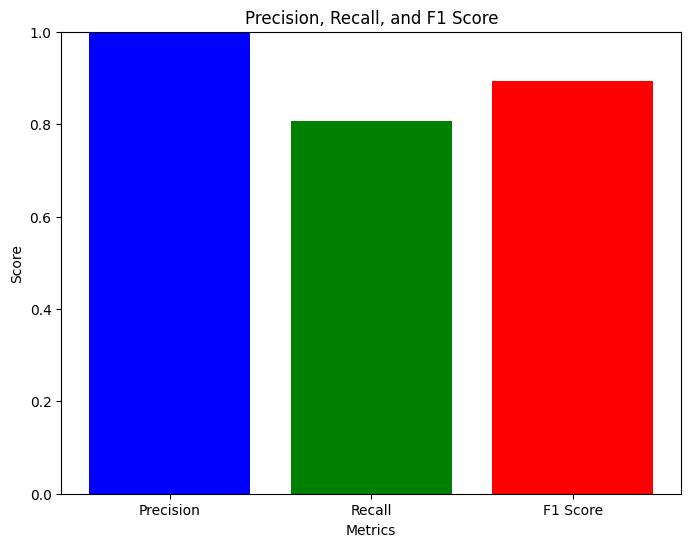

In [33]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Create a bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.ylim([0, 1])  # Since metrics are between 0 and 1
plt.show()


5/5 [==============================] - 0s 42ms/step


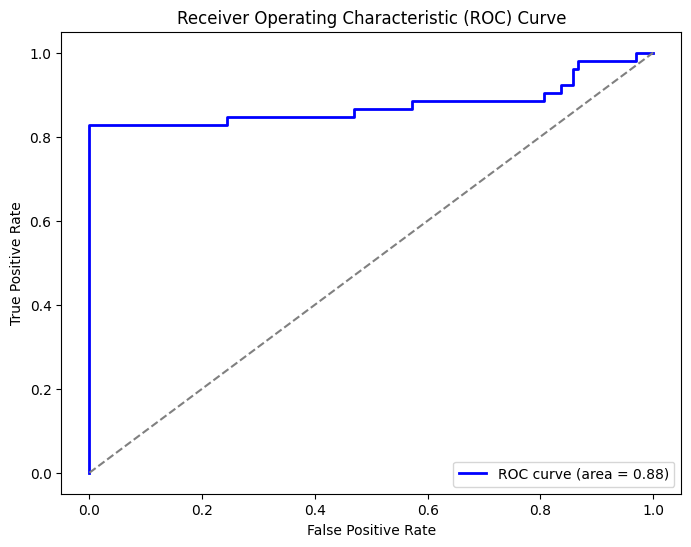

In [34]:
# Get the predicted probabilities
y_prob = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


5/5 [==============================] - 0s 28ms/step


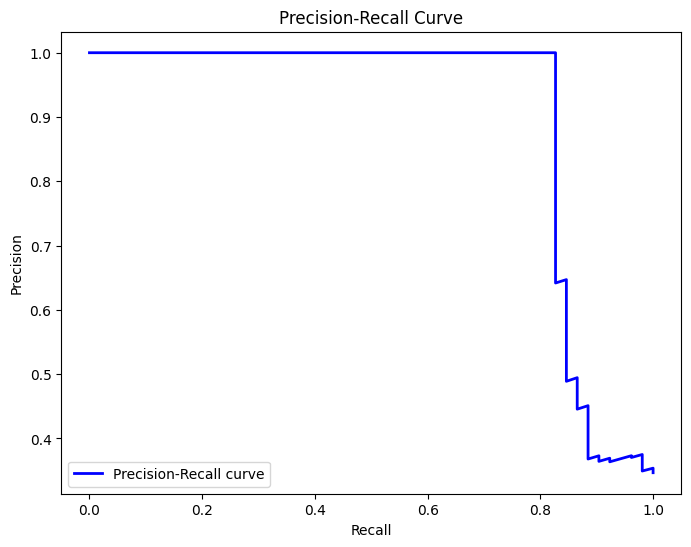

In [35]:
def plot_precision_recall_curve(y_test, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Get the predicted probabilities
y_prob = model.predict(X_test)
plot_precision_recall_curve(y_test, y_prob)


In [110]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler])


Epoch 1/100
34/34 [==============================] - 1s 10ms/step - loss: 0.1045 - accuracy: 0.9699 - val_loss: 0.3923 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0822 - accuracy: 0.9699 - val_loss: 0.4014 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.9624 - val_loss: 0.4665 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0781 - accuracy: 0.9699 - val_loss: 0.4227 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0737 - accuracy: 0.9699 - val_loss: 0.4380 - val_accuracy: 0.9500 - lr: 5.0000e-05
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0602 - accuracy: 0.9850 - val_loss: 0.4770 - val_accuracy: 0.9000 - lr: 5.0000e-05
Epoch 7/100
34/34 [==============================] 